### Visualizations of Graph Construction

This code shows how to build the visualizations presented in our manuscript. We use functions imported from WI_graph_functions.py to build the graphs and define their position dictionaries. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.colors as colors
%matplotlib inline
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import geopandas
import geopandas as gpd
from geopandas.tools import sjoin
import pandas as pd

from shapely.geometry import Point

import datetime

from tqdm import tqdm
import networkx as nx
from WI_graph_functions import *

In [2]:
# Load in the data for tofroms lists, waterbody/river shapefiles, and HUC shapefiles

WItofroms       = pd.read_csv("WIgeodataframes/WItofroms.csv")
WItofroms_lakes = pd.read_csv("WIgeodataframes/WItofroms_lakes.csv")
WItofroms_agg   = pd.read_csv("WIgeodataframes/WItofroms_agg.csv")

WILakes = pd.read_pickle("WILakes.df")
WIRivers = pd.read_pickle("WIRivers.df")

HUC8  = gpd.GeoDataFrame.from_file("WIgeodataframes/HUC8/HUC8.shp")
HUC10 = gpd.GeoDataFrame.from_file("WIgeodataframes/HUC10/HUC10.shp")
HUC12 = gpd.GeoDataFrame.from_file("WIgeodataframes/HUC12/HUC12.shp")

WI    = gpd.GeoDataFrame.from_file("lakes_rivers/WI/WI.shp")

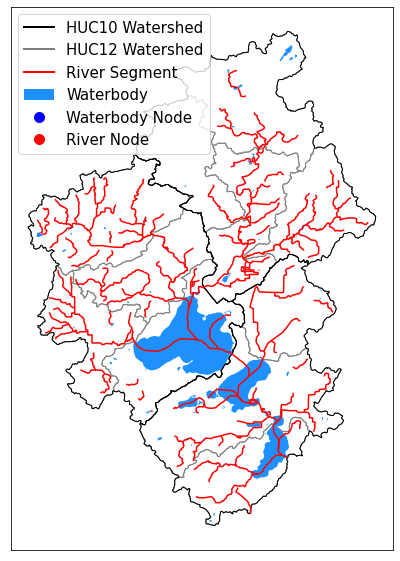

In [3]:
fig, ax = plt.subplots(figsize=(10,10))

# Define huc10s of interest
huc10s = [709000205, 709000206, 709000207]

# Plot the HUCs, rivers, and waterbodies
HUC10[HUC10.huc10.isin(huc10s)].plot(ax=ax, color="none", edgecolor="black")
HUC12[HUC12.huc10.isin(huc10s)].plot(ax=ax, color='none', edgecolor="grey",zorder=0)
WILakes[(WILakes.huc10.isin(huc10s))].plot(ax=ax, color="dodgerblue")
WIRivers[WIRivers.huc10.isin(huc10s)].plot(ax=ax, color='red')

legend_elements = [Line2D([0],[0], color="black", lw=2, label="HUC10 Watershed"),
                   Line2D([0],[0], color="grey", lw=2, label="HUC12 Watershed"),
                   Line2D([0],[0], color="red", lw=2, label="River Segment"),
                   Patch(facecolor="dodgerblue", edgecolor="none", label="Waterbody"),
                   Line2D([0],[0], markersize=10, label="Waterbody Node",marker='o', color='blue',linestyle="None"),
                   Line2D([0],[0], markersize=10, label="River Node",marker='o',color='red',linestyle="None")                   ]

ax.legend(handles=legend_elements, loc = 'upper left',fontsize=15)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

In [4]:
# Define all objects (rivers and waterbodies) that are within the huc10s of interst
fig_objs = pd.concat([WIRivers[WIRivers.huc10.isin(huc10s)], WILakes[WILakes.huc10.isin(huc10s)]])
# Get the COMIDs of these objects
fig_comids = fig_objs.COMID.values
# Get the to-from list that applies to these comids
fig_tofroms = WItofroms[WItofroms.TOCOMID.isin(fig_comids) & WItofroms.FROMCOMID.isin(fig_comids)]

In [5]:
# Build the river graph
G_rivs = build_graph(fig_tofroms)

In [6]:
# Define the position dictionary, the node colors, and the node sizes
G_rivs_pos, node_colors_rivs, node_size_rivs = get_pos_dict(G_rivs, WILakes, WIRivers)

100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:03<00:00, 64.77it/s]


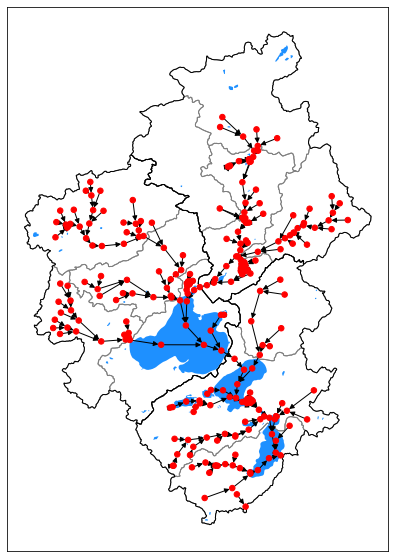

In [7]:
# Plot the river graph on top of the lakes

fig, ax = plt.subplots(figsize=(10,10))

HUC10[HUC10.huc10.isin(huc10s)].plot(ax=ax, color="none", edgecolor="black")
HUC12[HUC12.huc10.isin(huc10s)].plot(ax=ax, color='none', edgecolor="grey",zorder=0)
WILakes[(WILakes.huc10.isin(huc10s))].plot(ax=ax, color="dodgerblue")

nx.draw_networkx(G_rivs,ax=ax,pos=G_rivs_pos,node_size=(np.array(node_size_rivs)*3),with_labels=False,\
                 arrowsize=10,node_color=node_colors_rivs)


In [8]:
# Define the to-from list that includes lakes
fig_tofroms_lakes = WItofroms_lakes[WItofroms_lakes.TOCOMID.isin(fig_comids) & WItofroms_lakes.FROMCOMID.isin(fig_comids)]

In [9]:
# Build the graph from the to-from list
G_lakes = build_graph(fig_tofroms_lakes)

In [10]:
# Define the position dictionary, the node colors, and the node sizes
G_lakes_pos, node_colors_lakes, node_size_lakes = get_pos_dict(G_lakes, WILakes, WIRivers)

100%|████████████████████████████████████████████████████████████████████████████████| 177/177 [00:02<00:00, 75.97it/s]


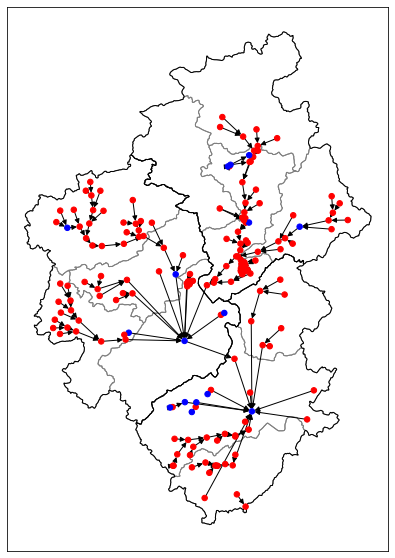

In [11]:
# Plot the resulting graph

fig, ax = plt.subplots(figsize=(10,10))

HUC10[HUC10.huc10.isin(huc10s)].plot(ax=ax, color="none", edgecolor="black")
HUC12[HUC12.huc10.isin(huc10s)].plot(ax=ax, color='none', edgecolor="grey",zorder=0)
legend_elements = [Line2D([0],[0], markersize=10, label="Waterbody Node",marker='o', color='blue',linestyle="None"),
                   Line2D([0],[0], markersize=10, label="River Node",marker='o',color='red',linestyle="None")                   ]

nx.draw_networkx(G_lakes,ax=ax,pos=G_lakes_pos,node_size=(np.array(node_size_lakes)*3),with_labels=False,arrowsize=10,node_color=node_colors_lakes)


In [12]:
# Define the to-from list for the aggregated graph
fig_tofroms_agg = WItofroms_agg[WItofroms_agg.TOCOMID.isin(fig_comids) & WItofroms_agg.FROMCOMID.isin(fig_comids)]

In [13]:
# Build the aggregated graph
G_agg = build_graph(fig_tofroms_agg)

In [14]:
# Define the position dictionary, the node colors, and the node sizes
G_agg_pos, node_colors_agg, node_size_agg = get_pos_dict(G_agg, WILakes, WIRivers)

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 75.01it/s]


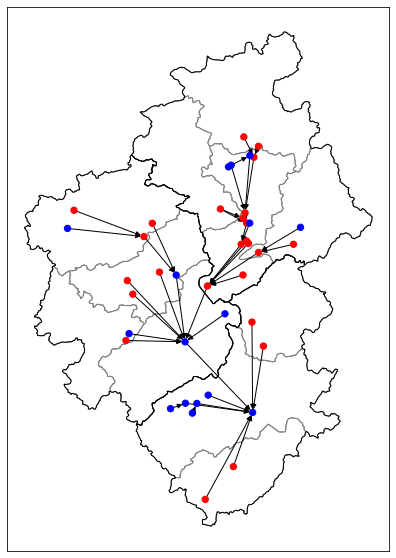

In [15]:
# Plot the aggregated graph

fig, ax = plt.subplots(figsize=(10,10))


HUC10[HUC10.huc10.isin(huc10s)].plot(ax=ax, color="none", edgecolor="black")
HUC12[HUC12.huc10.isin(huc10s)].plot(ax=ax, color='none', edgecolor="grey",zorder=0)

nx.draw_networkx(G_agg,ax=ax,pos=G_agg_pos,node_size=(np.array(node_size_agg)*4),with_labels=False,arrowsize=10,node_color=node_colors_agg)

## Plot the Entire state of Wisconsin

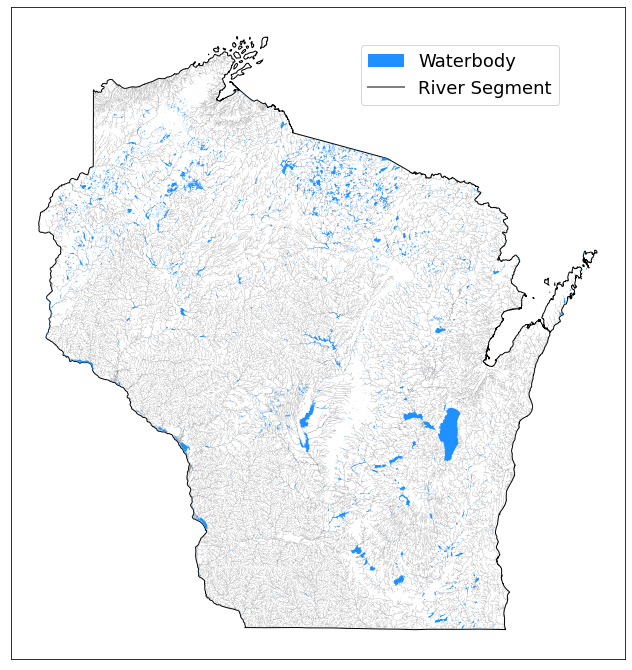

In [16]:
fig, ax = plt.subplots(figsize=(12,12))

WI.plot(ax=ax, color="none", edgecolor="black",zorder = 1)
WIRivers.plot(ax=ax, linewidth=.15,color=(.35,.35,.35),zorder = 2)
WILakes.plot(ax=ax, color="dodgerblue",zorder = 3)

legend_elements = [Patch(facecolor="dodgerblue", edgecolor="none", label="Waterbody"),
                   Line2D([0],[0], color="grey", lw=2, label="River Segment")]

ax.legend(handles=legend_elements, loc = (.57,.85),fontsize=18)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

#plt.savefig("updatedFig4.pdf")


## Plot the Graph for the state of Wisconsin

In [17]:
G_lakes = build_graph(WItofroms_lakes)

In [18]:
G_lakes_pos, node_colors_lakes, node_size_lakes = get_pos_dict(G_lakes,  WILakes, WIRivers)

100%|████████████████████████████████████████████████████████████████████████████| 45997/45997 [09:47<00:00, 78.34it/s]


In [19]:
for i in range(len(node_size_lakes)):
    if node_colors_lakes[i] == "red":
        node_size_lakes[i] = node_size_lakes[i]/10

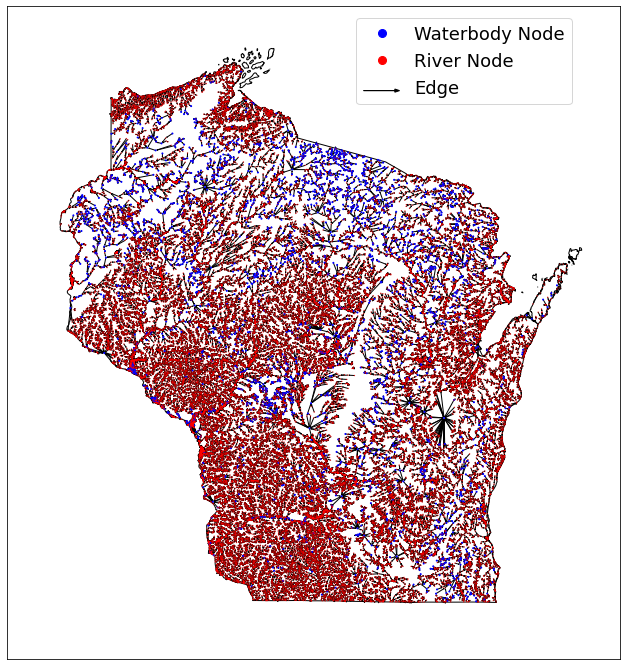

In [20]:
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
def make_legend_arrow(legend, orig_handle,
                      xdescent, ydescent,
                      width, height, fontsize):
    p = mpatches.FancyArrow(0, 0.2*height, width, 0, length_includes_head=True, head_width=0.25*height )
    return p
# See https://stackoverflow.com/questions/22348229/matplotlib-legend-for-an-arrow for how to add an arrow to the plot


fig, ax = plt.subplots(figsize=(12,12))

WI.plot(ax=ax, color="none",edgecolor="black")
legend_elements = [
                   Line2D([0],[0], markersize=8, label="Waterbody Node",marker='o', color='blue',linestyle="None"),
                   Line2D([0],[0], markersize=8, label="River Node",marker='o',color='red',linestyle="None"),
                   mpatches.FancyArrow(0,.5, .6, 0,label="Edge", color='k', length_includes_head = True, head_width = .75)]


ax.legend(handles=legend_elements, loc = (.57,.85),fontsize=18, handler_map = {mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow)})
nx.draw_networkx(G_lakes,pos=G_lakes_pos,node_size=np.array(node_size_lakes)/10,with_labels=False,ax=ax,arrowsize=1,node_color=node_colors_lakes)

#plt.savefig("updatedfig4_allnodes.pdf")

## Plot the aggregated form of the Graph

In [21]:
G_agg = build_graph(WItofroms_agg)

In [22]:
G_agg_pos, node_colors_agg, node_size_agg = get_pos_dict(G_agg, WILakes, WIRivers)

100%|██████████████████████████████████████████████████████████████████████████████| 8526/8526 [01:45<00:00, 80.47it/s]


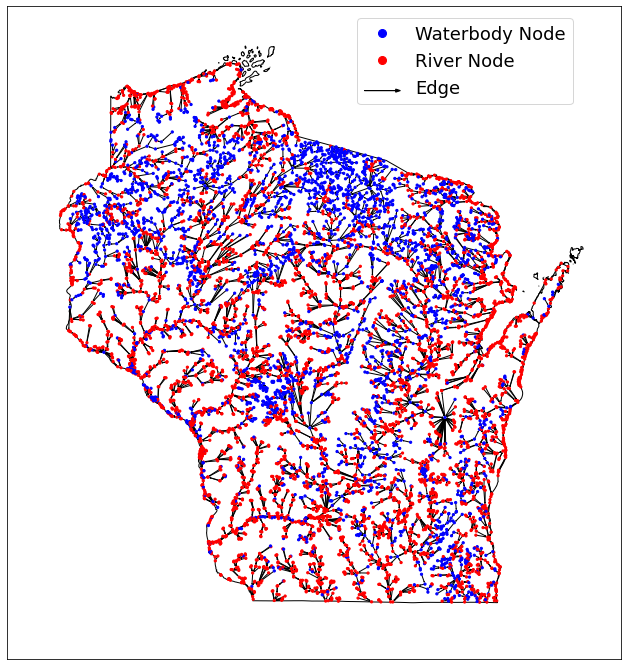

In [23]:
fig, ax = plt.subplots(figsize=(12,12))

WI.plot(ax=ax, color="none",edgecolor="black")
legend_elements = [
                   Line2D([0],[0], markersize=8, label="Waterbody Node",marker='o', color='blue',linestyle="None"),
                   Line2D([0],[0], markersize=8, label="River Node",marker='o',color='red',linestyle="None"),
                   mpatches.FancyArrow(0,.5, .6, 0,label="Edge", color='k', length_includes_head = True, head_width = .75)]

ax.legend(handles=legend_elements, loc = (.57,.85),fontsize=18, handler_map = {mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow)})
nx.draw_networkx(G_agg,pos=G_agg_pos,node_size=np.array(node_size_agg)/2,with_labels=False,ax=ax,arrowsize=1,node_color=node_colors_agg)

#plt.savefig("updated_Fig4_agg.pdf")

## Check Aggregation Connectivity

In [22]:
# Build the graphs for the aggregated and original graphs
glakes = build_graph(WItofroms_lakes)
gagg   = build_graph(WItofroms_agg)

# Define the set of all nodes in the aggregated graph
agg_nodes  = [i for i in gagg.nodes]

# Define the set of all lakes that arise in aggregated set
WILakes_set = WILakes[WILakes.COMID.isin(agg_nodes)]

# Loop through the lakes set
for i in tqdm(range(len(WILakes_set))):
    
    # Loop through the lakes set again
    for j in range(len(WILakes_set)):
        
        # Test if the lake of the inner loop has a path connecting it to the lake in the outer loop
        # Do this for both the aggregated and original problems. 
        gagg_bool = nx.has_path(gagg, WILakes_set.COMID.iloc[i], WILakes_set.COMID.iloc[j])
        glakes_bool = nx.has_path(glakes, WILakes_set.COMID.iloc[i], WILakes_set.COMID.iloc[j])
        
        # Test if the aggregated and original graphs have the same connection boolean for the given lakes
        # If gagg_bool is true but glakes_bool is false, then the aggregated graph connects two lakes 
        # that were not connected in the original graph; if glakes_bool is true and gagg_bool is false, 
        # then the aggregated graph removed a connection between lakes. If no statement is printed, then
        # the aggregated and original graphs have the same connectivity of lakes
        if gagg_bool==True and glakes_bool==True:
            pass    
        elif gagg_bool==False and glakes_bool==False:
            pass
        elif gagg_bool == True and glakes_bool == False:
            print("Aggregated is connected but Lakes is not;   iteration ", i, "  ", j)
            print(WILakes_set.COMID.iloc[i], "  and   ", WILakes_set.COMID.iloc[j])
            print()
        elif gagg_bool==False and glakes_bool==True:
            print("Lakes are connected but Aggregated is not")
            print(WILakes_set.COMID.iloc[i], "  and   ", WILakes_set.COMID.iloc[j])
            print()

100%|██████████████████████████████████████████████████████████████████████████████| 3199/3199 [26:10<00:00,  2.04it/s]
